In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
train_df=pd.read_csv('gdrive/My Drive/NLP_Project/train_data.csv')
oversampled_train_df=pd.read_csv('gdrive/My Drive/NLP_Project/oversampled_train_data.csv')
test_df=pd.read_csv('gdrive/My Drive/NLP_Project/test_data.csv')
train_df=train_df.drop([train_df.columns[0]],axis=1)
oversampled_train_df=oversampled_train_df.drop([oversampled_train_df.columns[0]],axis=1)
test_df=test_df.drop([test_df.columns[0]],axis=1)

Mounted at /content/gdrive


In [ ]:
data=train_df

In [ ]:
data

,transcription,medical_specialty
0,impression abnormal electroencephalogram revea...,36
1,family history father died leukemia mother die...,5
2,procedure cystourethroscopy transurethral rese...,10
3,preoperative diagnosis radioactive plaque macu...,26
4,"procedure ,1. esophagogastroduodenoscopy.,2 co...",38
...,...,...
3994,"preoperative diagnosis ,1. neuromuscular dysph...",14
3995,preoperative diagnosis c5-c6 disc herniation r...,38
3996,procedure direct-current cardioversion . brief...,38
3997,preoperative diagnosis prostate cancer . posto...,38


In [ ]:
data.rename(columns={'transcription':'text','medical_specialty':'label'},inplace=True)

In [ ]:
#data[['text','label']]=data[['text','label']].fillna("none")

**Splitting into train and Validation Set**

In [ ]:
df=data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')
labels_temp=encoder.fit_transform(np.array(df['label']).reshape(-1,1))

In [ ]:
labels_temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
train_text,train_labels=df['text'],labels_temp
val_text,val_labels=test_df['transcription'],encoder.fit_transform(np.array(test_df['medical_specialty']).reshape(-1,1))

In [ ]:
test_df

,transcription,medical_specialty
0,pap smear november 2006 showed atypical squamo...,24
1,preoperative diagnosis nonpalpable right undes...,39
2,exam lumbar spine ct without contrast . histor...,33
3,history present illness patient well known his...,16
4,heent history headache migraine vertigo syncop...,15
...,...,...
995,preoperative diagnosis chronic otitis medium ....,11
996,preoperative diagnosis bunion left foot . post...,27
997,preoperative diagnosis anterior cruciate ligam...,27
998,preoperative diagnosis chronic venous hyperten...,22


**Importing BERT and BERT Tokenizer**

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

<Axes: >

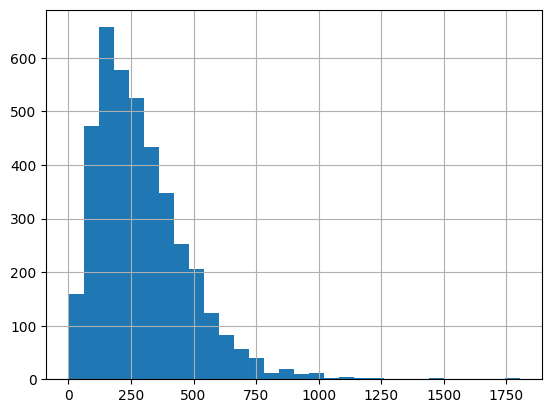

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len=500

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     padding='max_length',
#     truncation=True,
#     return_token_type_ids=False
# )

In [ ]:
# For over sampled data
# Set the batch size
# batch_size = 3000

# # Tokenize and encode sequences in the training set in batches
# num_train_samples = len(train_text)
# num_train_batches = (num_train_samples + batch_size - 1) // batch_size

# tokens_train = []
# for i in range(num_train_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, num_train_samples)

#     batch_text = train_text[start_idx:end_idx].tolist()

#     tokens_batch = tokenizer.batch_encode_plus(
#         batch_text,
#         max_length=max_seq_len,
#         padding='max_length',
#         truncation=True,
#         return_token_type_ids=False
#     )

#     tokens_train.append(tokens_batch)

# # Tokenize and encode sequences in the validation set in batches
# num_val_samples = len(val_text)
# num_val_batches = (num_val_samples + batch_size - 1) // batch_size

# tokens_val = []
# for i in range(num_val_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, num_val_samples)

#     batch_text = val_text[start_idx:end_idx].tolist()

#     tokens_batch = tokenizer.batch_encode_plus(
#         batch_text,
#         max_length=max_seq_len,
#         padding='max_length',
#         truncation=True,
#         return_token_type_ids=False
#     )

#     tokens_val.append(tokens_batch)



# # Combine the batches for each set
# tokens_train_combined = {}
# for key in tokens_train[0].keys():
#     tokens_train_combined[key] = [item[key] for batch in tokens_train for item in batch[key]]

# tokens_val_combined = {}
# for key in tokens_val[0].keys():
#     tokens_val_combined[key] = [item[key] for batch in tokens_val for item in batch[key]]



# Now, tokens_train_combined, tokens_val_combined, and tokens_test_combined contain the tokenized data


TypeError: ignored

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

**Creating DataLoaders**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
bert.parameters

In [ ]:
count=0
for param in bert.parameters():
    count+=1
    param.requires_grad = False

In [ ]:
for param in bert.parameters():
  if count<=10:
    param.requires_grad=True;

  count-=1

In [ ]:
# for param in bert.parameters():
#     if count<=3:
#       param.requires_grad = True
#     count-=1

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,40)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x


In [ ]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [ ]:
train_labels

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_labels is a 2D numpy array with one-hot encoded labels
# First, convert one-hot encoded labels to integer labels
train_labels_int = np.argmax(train_labels, axis=1)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_int), y=train_labels_int)

print("Class Weights:", class_weights)


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

# number of training epochs
epochs = 30

In [ ]:
# # function to train the model
# def train():

#   model.train()

#   total_loss, total_accuracy = 0, 0

#   # empty list to save model predictions
#   total_preds=[]

#   # iterate over batches
#   for step,batch in enumerate(train_dataloader):

#     # progress update after every 50 batches.
#     if step % 50 == 0 and not step == 0:
#       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

#     # push the batch to gpu
#     batch = [r.to(device) for r in batch]

#     sent_id, mask, labels = batch

#     # clear previously calculated gradients
#     model.zero_grad()

#     # get model predictions for the current batch
#     preds = model(sent_id, mask)

#     # compute the loss between actual and predicted values
#     loss = cross_entropy(preds, labels)

#     # add on to the total loss
#     total_loss = total_loss + loss.item()

#     # backward pass to calculate the gradients
#     loss.backward()

#     # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#     # update parameters
#     optimizer.step()

#     # model predictions are stored on GPU. So, push it to CPU
#     preds=preds.detach().cpu().numpy()

#     # append the model predictions
#     total_preds.append(preds)

#   # compute the training loss of the epoch
#   avg_loss = total_loss / len(train_dataloader)

#   # predictions are in the form of (no. of batches, size of batch, no. of classes).
#   # reshape the predictions in form of (number of samples, no. of classes)
#   total_preds  = np.concatenate(total_preds, axis=0)
#   print(f"--Loss: {avg_loss}")
#   #returns the loss and predictions
#   return avg_loss, total_preds

def train():
    model.train()

    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(train_dataloader, 1):  # Start step from 1 for cleaner output
        if step % 50 == 0:
            print(f"Training Batch [{step}/{len(train_dataloader)}]")

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    print(f"Training Loss: {avg_loss:.4f}")
    return avg_loss, total_preds


In [ ]:
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
import torch

# Set max split size to 256 MB (adjust as needed)
torch._C._cuda_setMaxSplitSize(256)

AttributeError: ignored

In [ ]:
allocator = torch.cuda.memory._get_memory_allocator()

    # Update max_split_size_mb in the memory allocator
allocator.set_max_split_size(200 * 1024 * 1024)

AttributeError: ignored

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30


OutOfMemoryError: ignored

In [ ]:
prediction_train=[]
actual_train=[]

data_inference=train_data
with torch.no_grad():  # Disable gradient tracking during inference
    for i in range(len(data_inference)):  # Iterate through the dataset
        t_seq, t_mask,t_y = data_inference[i]

        # Move input data to the GPU
        t_seq = t_seq.to(device)
        t_mask = t_mask.to(device)

        outputs = model(t_seq.unsqueeze(0),t_mask.unsqueeze(0)).detach().cpu().numpy()
        outputs = np.argmax(outputs.squeeze(),axis=0)

        prediction_train.append(outputs)
        t_y=t_y.cpu().numpy()
        t_y=np.argmax(t_y,axis=0)
        actual_train.append(t_y)


In [ ]:
!pip install torcheval

In [ ]:
prediction_train=torch.tensor(prediction_train)
actual_train=torch.tensor(actual_train)
from torcheval.metrics.functional import multiclass_f1_score
train_f1_score=multiclass_f1_score(prediction_train,actual_train,num_classes=40,average='micro')
print(f"Train F1 score: {train_f1_score}")

In [ ]:
prediction_test=[]
actual_test=[]

data_inference=test_data
with torch.no_grad():  # Disable gradient tracking during inference
    for i in range(len(data_inference)):  # Iterate through the dataset
        t_seq, t_mask,t_y = data_inference[i]

        # Move input data to the GPU
        t_seq = t_seq.to(device)
        t_mask = t_mask.to(device)

        outputs = model(t_seq.unsqueeze(0),t_mask.unsqueeze(0)).detach().cpu().numpy()
        outputs = np.argmax(outputs.squeeze(),axis=0)

        prediction_test.append(outputs)
        t_y=t_y.cpu().numpy()
        t_y=np.argmax(t_y,axis=0)
        actual_test.append(t_y)

In [ ]:
prediction_test=torch.tensor(prediction_test)
actual_test=torch.tensor(actual_test)
from torcheval.metrics.functional import multiclass_f1_score
test_f1_score=multiclass_f1_score(prediction_test,actual_test,num_classes=40,average='micro')
print(f"Train F1 score: {test_f1_score}")

In [ ]:
from torcheval.metrics.functional import multiclass_confusion_matrix

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.heatmap(multiclass_confusion_matrix(prediction_test, actual_test, 40), linewidth=0.5)
plt.show()